In [57]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
from tensorflow import keras 

import os
from scipy.stats import spearmanr
from math import floor, ceil
!pip install transformers
!pip install sentencepiece
from transformers import *

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

2.4.1


# Prep / tokenizer

#### 1. Read data and tokenizer

Read tokenizer and data, as well as defining the maximum sequence length that will be used for the input to Bert (maximum is usually 512 tokens)

In [59]:
training_sample_count = 6400
training_epochs = 2
test_count = 1600

running_folds = 1

MAX_SENTENCE_LENGTH = 20 # max number of words in a sentence
MAX_SENTENCES = 5 # max number of sentences to encode in a text

MAX_LENGTH = 100 # max words in a text as whole sentences

In [60]:
%cd '/content/drive/MyDrive/CSCE 638 NLP Project/LOL_Data/'
!ls

/content/drive/MyDrive/CSCE 638 NLP Project/LOL_Data
model_plot.png	public_dat  public_test  test1600.csv  train6400.csv  train.csv


### original dataset

In [61]:
df = pd.read_csv('train.csv')

df_train = pd.read_csv('train6400.csv')
display(df_train.head(3))
df_train = df_train[:training_sample_count*running_folds]

df_test = pd.read_csv('test1600.csv')
display(df_test.head(3))
df_test = df_test[:test_count]

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4


,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,6401,Why are most cemeteries fenced in? Because eve...,1,2.75,0.0,0.15
1,6402,I'm so excited to finally get a dad bod It's t...,1,2.90,1.0,0.20
2,6403,Soft kisses..... We love them.,0,NaN,NaN,0.00


In [62]:
print(df.describe())
print(df_train.describe())
print(df_test.describe())

print(sum(df_train['is_humor']==0)/len(df_train['is_humor']))
print(sum(df_test['is_humor']==0)/len(df_test['is_humor']))
print(df_test.describe())

               id     is_humor  humor_rating  humor_controversy  offense_rating
count  8000.00000  8000.000000   4932.000000        4932.000000     8000.000000
mean   4000.50000     0.616500      2.260525           0.499797        0.585325
std    2309.54541     0.486269      0.566974           0.500051        0.979955
min       1.00000     0.000000      0.100000           0.000000        0.000000
25%    2000.75000     0.000000      1.890000           0.000000        0.000000
50%    4000.50000     1.000000      2.280000           0.000000        0.100000
75%    6000.25000     1.000000      2.650000           1.000000        0.700000
max    8000.00000     1.000000      4.000000           1.000000        4.850000
                id     is_humor  ...  humor_controversy  offense_rating
count  6400.000000  6400.000000  ...        3963.000000     6400.000000
mean   3200.500000     0.619219  ...           0.502397        0.587539
std    1847.665193     0.485617  ...           0.500057        0

In [63]:
output_categories = list(df_train.columns[[2]])
input_categories = list(df_train.columns[[1]])

TARGET_COUNT = len(output_categories)

print('\ninput categories:\n\t', input_categories)
print('\noutput TARGET_COUNT:\n\t', TARGET_COUNT)
print('\noutput categories:\n\t', output_categories)


input categories:
	 ['text']

output TARGET_COUNT:
	 1

output categories:
	 ['is_humor']


## 2. Preprocessing functions

These are some functions that will be used to preprocess the raw text data into useable Bert inputs.<br>


In [64]:
from transformers import BertTokenizer

MODEL_TYPE = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

In [65]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
def return_id(str1, str2, truncation_strategy, length):

    inputs = tokenizer.encode_plus(str1, str2,
        add_special_tokens=True,
        max_length=length,
        truncation_strategy=truncation_strategy)

    input_ids =  inputs["input_ids"] #token indices, numerical representations of tokens building the sequences that will be used as input by the model
    input_masks = [1] * len(input_ids) # indicate the ids should be attended
    input_segments = inputs["token_type_ids"] #BERT, also deploy token type IDs (also called segment IDs). They are represented as a binary mask identifying the two types of sequence in the model.

    padding_length = length - len(input_ids)
    padding_id = tokenizer.pad_token_id

    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer):

    model_input = []
    for xx in range((MAX_SENTENCES*3)+3): # +3 for the whole sentences
        model_input.append([])
    
    for _, row in tqdm(df[columns].iterrows()):
        #print(type(row))
        #print(row)
        #print(row.text)
        #print(type(row.text))
        #stop

        i = 0
        
        # sent
        sentences = sent_tokenize(row.text) # separate a long text into sentences

        for xx in range(MAX_SENTENCES): # MAX_SENTENCES = 5

            s = sentences[xx] if xx<len(sentences) else ''

            ids_q, masks_q, segments_q = return_id(s, None, 'longest_first', MAX_SENTENCE_LENGTH) #MAX_SENTENCE_LENGTH = 20

            model_input[i].append(ids_q)
            i+=1
            model_input[i].append(masks_q)
            i+=1
            model_input[i].append(segments_q)
            i+=1
        
        # full row
        ids_q, masks_q, segments_q = return_id(row.text, None, 'longest_first', MAX_LENGTH) # MAX_LENGTH = 100

        model_input[i].append(ids_q)
        i+=1
        model_input[i].append(masks_q)
        i+=1
        model_input[i].append(segments_q)
        
    for xx in range((MAX_SENTENCES*3)+3):
        model_input[xx] = np.asarray(model_input[xx], dtype=np.int32)
        
    print(model_input[0].shape)

    return model_input

inputs      = compute_input_arrays(df_train, input_categories, tokenizer)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



(6400, 20)



(1600, 20)


In [67]:
print(len(inputs), len(inputs[0]), len(inputs[0][0]))

# check out input for 7th row
xx = 7
print(df_train.iloc[xx,1])
print(sent_tokenize(df_train.iloc[xx,1]))
inputs[0][xx], inputs[3][xx], inputs[6][xx], inputs[15][xx]

18 6400 20
ME: I'm such an original. Truly one of a kind. ALSO ME: [holding a glass of white wine] I love to laugh.
["ME: I'm such an original.", 'Truly one of a kind.', 'ALSO ME: [holding a glass of white wine] I love to laugh.']


(array([ 101, 2033, 1024, 1045, 1005, 1049, 2107, 2019, 2434, 1012,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 101, 5621, 2028, 1997, 1037, 2785, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 101, 2036, 2033, 1024, 1031, 3173, 1037, 3221, 1997, 2317, 4511,
        1033, 1045, 2293, 2000, 4756, 1012,  102,    0,    0], dtype=int32),
 array([ 101, 2033, 1024, 1045, 1005, 1049, 2107, 2019, 2434, 1012, 5621,
        2028, 1997, 1037, 2785, 1012, 2036, 2033, 1024, 1031, 3173, 1037,
        3221, 1997, 2317, 4511, 1033, 1045, 2293, 2000, 4756, 1012,  102,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    

In [68]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

outputs = compute_output_arrays(df_train, output_categories)
test_outputs = compute_output_arrays(df_test, output_categories)

## 3. Create model



In [69]:
#config = BertConfig() # print(config) to see settings
#config.output_hidden_states = False # Set to True to obtain hidden states
#bert_model = TFBertModel.from_pretrained('bert-large-uncased', config=config)
bert_model = TFBertModel.from_pretrained("bert-large-uncased")
config

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-large-uncased",
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [70]:
def create_model():
    # model structure
    # takes q_ids [max=20*MAX_SENTENCES] and a_ids [max=200]
    import gc
    
    model_inputs = []
    f_inputs=[]

    for i in range(MAX_SENTENCES):
        
        # bert embeddings
        q_id = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_mask = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_atn = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_embedding = bert_model(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
        q = tf.keras.layers.GlobalAveragePooling1D()(q_embedding)
        
        # internal model
        hidden1 = keras.layers.Dense(32, activation="relu")(q)
        hidden2 = keras.layers.Dropout(0.3)(hidden1)
        hidden3 = keras.layers.Dense(8, activation='relu')(hidden2)
        
        f_inputs.append(hidden3)
        model_inputs.extend([q_id, q_mask, q_atn])
        
    # whole sentence
    a_id = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_embedding = bert_model(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]
    a = tf.keras.layers.GlobalAveragePooling1D()(a_embedding)
    print(a.shape)
    
    # internal model
    hidden1 = keras.layers.Dense(256, activation="relu")(a)
    hidden2 = keras.layers.Dropout(0.2)(hidden1)
    hidden3 = keras.layers.Dense(64, activation='relu')(hidden2)

    f_inputs.append(hidden3)
    model_inputs.extend([a_id, a_mask, a_atn])
    
    # final classifier
    concat_ = keras.layers.Concatenate()(f_inputs)
    hiddenf1 = keras.layers.Dense(512, activation='relu')(concat_)
    hiddenf2 = keras.layers.Dropout(0.2)(hiddenf1)
    hiddenf3 = keras.layers.Dense(256, activation='relu')(hiddenf2)
    
    output = keras.layers.Dense(TARGET_COUNT, activation='sigmoid')(hiddenf3) # softmax
    model = keras.Model(inputs=model_inputs, outputs=[output] )
    
    gc.collect()
    return model

model = create_model()
model.summary()

(None, 1024)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
_________________________________________________________________________________

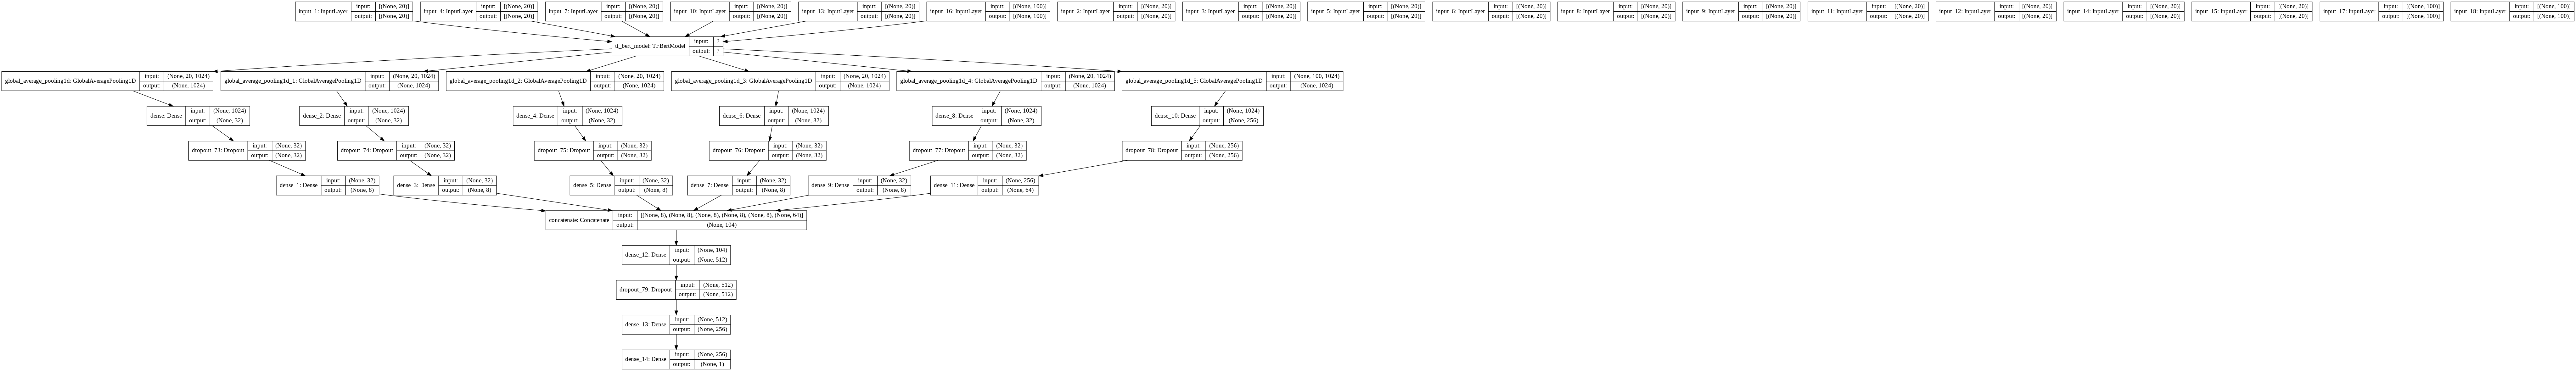

In [71]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 5. Training, validation and testing

Loops over the folds in gkf and trains each fold for 3 epochs --- with a learning rate of 3e-5 and batch_size of 6. A simple binary crossentropy is used as the objective-/loss-function. 

In [72]:
# Evaluation Metrics
import sklearn

def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):

    print('==================', label2)
    ### For regression
    if is_regression:
        print("Regression task returns: MSE")
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred)
    else:
        ### FOR Classification
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
        
        print("Classification returns: Acc")

        print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))
        
        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print(matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Acc', Accuracy, 'Prec', Precision, 'Rec', Recall, 'F1',F1)

        return sklearn.metrics.accuracy_score(y_true, y_pred)

print_evaluation_metrics([1,0], [0.9,0.1], '', True)
print_evaluation_metrics([1,0], [1,1], '', False)

Regression task returns: MSE
mean_absolute_error  : 0.09999999999999999
mean_squared_error  : 0.009999999999999998
r2 score  : 0.96
Classification returns: Acc
f1_score  : 0.6666666666666666
[[0 1]
 [0 1]]
Acc 0.5 Prec 0.5 Rec 1.0 F1 0.6666666666666666


0.5

### Loss function selection
Regression problem between 0 and 1, so binary_crossentropy and mean_absolute_error seem good.

Here are the explanations: https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

In [73]:
min_acc = 100
min_test = []

#valid_preds = []
test_preds = []
best_model = False


for BS in [6]:
    LR = 1e-5
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('LR=', LR)

    gkf = GroupKFold(n_splits=2).split(X=df_train.text, groups=df_train.text)

    for fold, (train_idx, valid_idx) in enumerate(gkf):

        if fold not in range(running_folds):
            continue

        train_inputs = [(inputs[i][:])[:training_sample_count] for i in range(len(inputs))]
        train_outputs = (outputs[:])[:training_sample_count]

        #train_inputs = [(inputs[i][train_idx])[:training_sample_count] for i in range(len(inputs))]
        #train_outputs = (outputs[train_idx])[:training_sample_count]

        #valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        #valid_outputs = outputs[valid_idx]

        #print(len(train_idx), len(train_outputs))

        model = create_model()
        K.clear_session()
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        print('model compiled')
        
        model.fit(train_inputs, train_outputs, epochs=training_epochs, batch_size=BS, verbose=1,
#                 validation_split=0.2, 
#                  validation_data=(x_val, y_val)
                 )
        # model.save_weights(f'bert-{fold}.h5')
        #valid_preds.append(model.predict(valid_inputs))

        test_preds.append(model.predict(test_inputs))
        
        acc = print_evaluation_metrics(np.array(test_outputs), np.array(test_preds[-1]), 'on #'+str(xx+1))

        if acc < min_acc:
            print('new acc >> ', acc)
            min_acc = acc
            best_model = model

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LR= 1e-05
(None, 1024)
model compiled
Epoch 1/2
 599/1067 [===============>..............] - ETA: 7:29 - loss: 0.5402

KeyboardInterrupt: ignored

## Regression submission

In [ ]:
df_sub = df_test.copy(deep=True)

min_test = best_model.predict(test_inputs)
df_sub['is_humor_pred'] = min_test

print_evaluation_metrics(df_sub['is_humor'], df_sub['is_humor_pred'], '', True)

df_sub.head()

## Binary submission

In [ ]:
for split in np.arange(0.1, 0.99, 0.1).tolist():
    df_sub['pred_bi'] = (df_sub['is_humor_pred'] > split)

    print_evaluation_metrics(df_sub['is_humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(split))

    df_sub.head()

In [ ]:
split = 0.5

df_sub['pred_bi'] = (df_sub['is_humor_pred'] > split)

print_evaluation_metrics(df_sub['is_humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(split))

#df_sub.to_csv('sub3.csv', index=False)
df_sub.head()

In [ ]:
df_sub[df_sub['pred_bi']!=df_sub['is_humor']]